# 1. Import Dependencies

In [13]:
import os
import cv2
import joblib
import pyttsx3
import numpy as np
import seaborn as sns
import mediapipe as mp
import tensorflow as tf
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.layers import TimeDistributed, Flatten, LSTM, Dense, Dropout, BatchNormalization, InputLayer



# 2. Keypoints using MP Holistic

In [17]:
# Load Mediapipe modules for holistic detection and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Define custom pose landmark connections for drawing
POSE_LANDMARKS_CONNECTIONS = [
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16),
    (11, 12),
    (16, 18),
    (18, 20),
    (20, 22),
    (16, 20), 
    (16, 22),  
    (15, 17),  
    (15, 19),  
    (15, 21), 
    (17, 19), 
    (21, 19),  
]

# Function to process an image with Mediapipe and return results
def mediapipe_detection(image, model):

    # Convert the image to RGB for Mediapipe processing
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image.flags.writeable = False  # Optimize image for processing

    results = model.process(image)  # Process the image with the Mediapipe model

    image.flags.writeable = True   # Re-enable image editing

    # Convert the image back to BGR for OpenCV visualization
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    return image, results

# Function to draw landmarks and connections
def draw_landmarks(image, results):

    # Draw pose landmarks and custom connections
    if results.pose_landmarks:

        landmarks = results.pose_landmarks.landmark  # Get all pose landmarks

        for connection in POSE_LANDMARKS_CONNECTIONS:

            start_idx, end_idx = connection
            start = landmarks[start_idx]  # Start landmark
            end = landmarks[end_idx]  # End landmark

            # Calculate coordinates of landmarks on the image
            x1, y1 = int(start.x * image.shape[1]), int(start.y * image.shape[0])
            x2, y2 = int(end.x * image.shape[1]), int(end.y * image.shape[0])

            # Draw line between landmarks
            cv2.line(image, (x1, y1), (x2, y2), (121, 22, 76), 2)

            # Draw circles at each landmark
            cv2.circle(image, (x1, y1), 5, (121, 44, 250), -1)
            cv2.circle(image, (x2, y2), 5, (121, 44, 250), -1)

    # Draw left-hand landmarks using Mediapipe utilities
    if results.left_hand_landmarks:

        mp_drawing.draw_landmarks(
            image, 
            results.left_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS,  # Predefined hand connections
            mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
        )
    
    # Draw right-hand landmarks using Mediapipe utilities
    if results.right_hand_landmarks:

        mp_drawing.draw_landmarks(
            image, 
            results.right_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS,  # Predefined hand connections
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

# Initialize webcam video capture
cap = cv2.VideoCapture(0)

# Use Mediapipe's holistic model with custom detection and tracking thresholds
with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:

    while cap.isOpened():  # Loop until the webcam is closed

        ret, frame = cap.read()  # Read a frame from the webcam

        if not ret:
            break  # Exit if no frame is captured

        frame = cv2.flip(frame, 1)  # Flip the frame horizontally

        # Process the frame using the Mediapipe model
        image, results = mediapipe_detection(frame, holistic)

        # Draw custom landmarks and connections
        draw_landmarks(image, results)

        # Display the processed frame
        cv2.imshow('Just draw landmarks', image)

        # Exit the loop when 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


# 3. Extract Keypoint Values

In [18]:
# Load Mediapipe modules for holistic detection and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Define custom pose landmark connections for drawing
POSE_WANT = [
    (0, 2),
    (2, 4),
    (1, 3),
    (3, 5),
    (0, 1),
    (5, 7),
    (7, 9),
    (9, 11),
    (5, 9),
    (5, 11),
    (4, 6),
    (4, 8),
    (4, 10),
    (6, 8),
    (10, 8),
]
# function to extract keypoints from Mediapipe results
def extract_keypoints(results):

    # Extract body, left hand, and right hand landmarks
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark[11:23]]) if results.pose_landmarks else np.zeros((12, 3))
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))

    # Use Mediapipe connections for pose and hands
    hand_connections = mp_holistic.HAND_CONNECTIONS

    # Create lists to store pose relationships
    pose_relationships = []
    if POSE_WANT:
        for connection in POSE_WANT:
            start_idx, end_idx = connection
            pose_relationships.append([pose[start_idx], pose[end_idx]])
    
    # Create lists to store left hand relationships
    lh_relationships = []
    if hand_connections:
        for connection in hand_connections:
            start_idx, end_idx = connection
            lh_relationships.append([lh[start_idx], lh[end_idx]])
    
    # Create lists to store right hand relationships
    rh_relationships = []
    if hand_connections:
        for connection in hand_connections:
            start_idx, end_idx = connection
            rh_relationships.append([rh[start_idx], rh[end_idx]])

    # Combine pose, left hand, and right hand keypoints into one array
    all_points = np.concatenate([pose, lh, rh], axis=0)

    # Combine keypoints and relationships into one array
    all_data = []

    # Add keypoints
    for point in all_points:
        all_data.append(point)

    # Add relationships between keypoints
    for relationship in pose_relationships + lh_relationships + rh_relationships:
        all_data.append(relationship[0])  # Start point
        all_data.append(relationship[1])  # End point

    # Convert to a numpy array
    all_data = np.array(all_data)

    return all_data


# 4. Setup Folders for Collection

In [5]:
# stores folder names in a list
folder_path = 'data'
folder_names = []
if os.path.exists(folder_path):folder_names = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
print(folder_names)

['about', 'aims', 'are', 'being', 'developing', 'everyone', 'excited', 'for', 'graduation', 'hello', 'here', 'is', 'make', 'NO_Act', 'our', 'present', 'project', 'sign language', 'system', 'thank', 'to', 'Today', 'we', 'which', 'you']


In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('data') 

# Actions that we try to detect
actions = np.array(folder_names)

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Create a folder for each action
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass
print(actions)

['about' 'aims' 'are' 'being' 'developing' 'everyone' 'excited' 'for'
 'graduation' 'hello' 'here' 'is' 'make' 'NO_Act' 'our' 'present'
 'project' 'sign language' 'system' 'thank' 'to' 'Today' 'we' 'which'
 'you']


# 5. Collect Keypoint Values for Training and Testing

In [12]:
# Open webcam
cap = cv2.VideoCapture(0)

# Set up the Mediapipe holistic model with detection and tracking confidence
with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3) as holistic:
    
    # Loop through actions (e.g., "wave", "point", etc.)
    for action in actions:
        # Loop through sequences (number of videos per action)
        for sequence in range(no_sequences):
            # Loop through frames in each sequence (video length)
            for frame_num in range(sequence_length):
                
                # Read a frame from the webcam
                ret, frame = cap.read()
                
                frame = cv2.flip(frame, 1)  # Flip the frame horizontally for a mirrored view
                
                # Process the frame to detect landmarks using Mediapipe
                image, results = mediapipe_detection(frame, holistic)
                
                # Draw pose and hand landmarks on the frame
                draw_landmarks(image, results)
                
                # Logic for displaying "STARTING COLLECTION" at the beginning of a sequence
                if frame_num == 0: 
                    # Display starting message
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show the frame with the message and wait for 2 seconds
                    cv2.imshow('Collecting Data', image)
                    cv2.waitKey(2000)
                else:
                    # Display action and sequence information during collection
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show the frame with the information
                    cv2.imshow('Collecting Data', image)
                
                # Extract keypoints (pose, left-hand, right-hand) from the results
                keypoints = extract_keypoints(results)
                
                # Define the file path to save keypoints as a .npy file
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                
                # Save the keypoints as a .npy file
                np.save(npy_path, keypoints)
                
                # Allow the user to quit by pressing 'q'
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                
# Release the webcam and close any OpenCV windows
cap.release()
cv2.destroyAllWindows()


# 6. Preprocess Data and Create Labels and Features

In [8]:
# Create a mapping of action labels to numeric values
label_map = {label: num for num, label in enumerate(actions)}

# Initialize empty lists for sequences (input data) and labels (output data)
sequences, labels = [], []

# Loop through each action
for action in actions:
    # Loop through each sequence for the given action
    for sequence in range(no_sequences):
    
        window = []  # Initialize an empty list to store frames for a single sequence
        
        # Loop through each frame in the sequence
        for frame_num in range(sequence_length):
        
            # Load the .npy file for the frame
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)  # Append the frame's keypoints to the window
        
        # Add the window (sequence of frames) to the sequences list
        sequences.append(window)

        # Add the corresponding label for this sequence to the labels list
        labels.append(label_map[action])

# Convert the sequences and labels into NumPy arrays
X = np.array(sequences)  # Input data (sequences of keypoints)
y = to_categorical(labels).astype(int)  # Output data (one-hot encoded labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)

# Print the shapes of the datasets for verification
print(X.shape)        # Total shape of the dataset
print(X_train.shape)  # Shape of the training data
print(X_test.shape)   # Shape of the test data
print(y[0])   # Shape of the testing data

(750, 30, 168, 3)
(690, 30, 168, 3)
(60, 30, 168, 3)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# 7. Build and Train SVM Model

In [9]:
# Flatten the training and test data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Fit the SVM classifier
SVM_classifier = SVC(probability=True, kernel='linear')
SVM_classifier.fit(X_train_flat, y_train.argmax(axis=1))

# Predicting the Test set results
y_pred = SVM_classifier.predict(X_test_flat)

# 8. Build and Train LSTM Neural Network

In [10]:
# Define the callback for TensorBoard
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# Define the model
model = Sequential()

# Input normalization
model.add(InputLayer(input_shape=(30,168,3)))
model.add(TimeDistributed(Flatten()))

# LSTM layers with Batch Normalization and Dropout
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

# Final output layer
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\smamh\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [91]:
# train Lstm model
his=model.fit(X_train, y_train,batch_size=32, epochs=180, callbacks=[tb_callback])

Epoch 1/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.0603 - loss: 3.6000
Epoch 2/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0888 - loss: 3.2900
Epoch 3/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1025 - loss: 2.9779
Epoch 4/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1755 - loss: 2.8473
Epoch 5/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1825 - loss: 2.6711
Epoch 6/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2332 - loss: 2.5583
Epoch 7/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2384 - loss: 2.3676
Epoch 8/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3330 - loss: 2.2044
Epoch 9/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3523 - loss: 2.0267
Epoch 10/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3726 - loss: 1.9136
Epoch 11/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3850 - loss: 1.8253
Epoch 12/180
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

# 9. Evaluation using Confusion Matrix and Accuracy

Accuracy: 0.9833333333333333
                precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      0.83      0.91         6
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         4
          18       1.00      1.00      1.00       

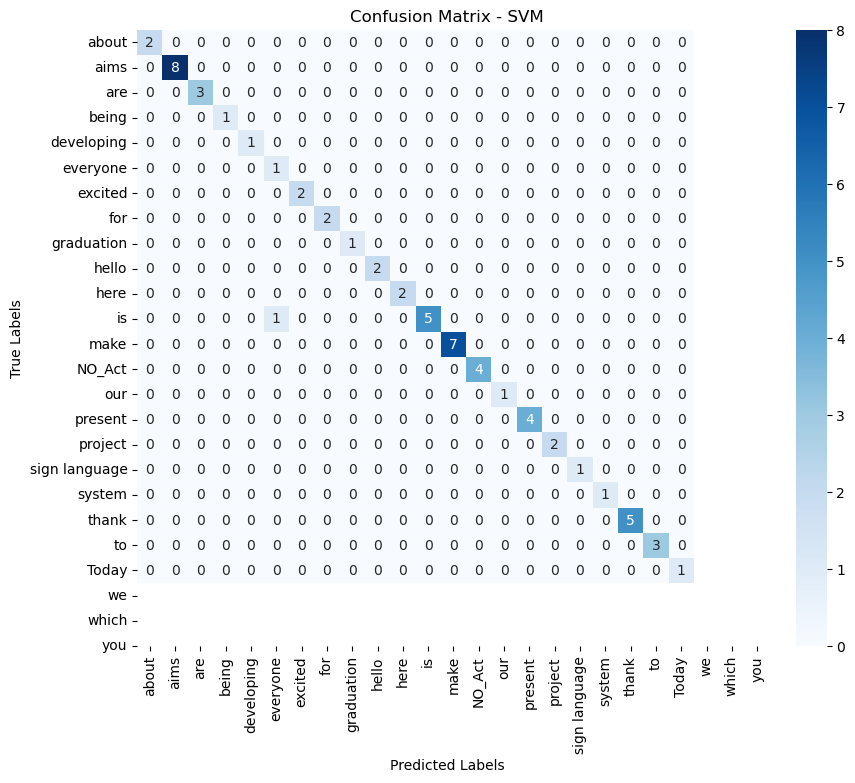

In [ ]:
# Define the labels for the categories
labels = actions

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)

# Calculate the classification report
classification=classification_report(y_test.argmax(axis=1), y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

# Print the accuracy, classification report
print("Accuracy:", accuracy)
print( ' ',classification)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVM')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
we
we
0.9507246376811594
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.87      0.93        30
           2       1.00      0.97      0.98        30
           3       1.00      1.00      1.00        22
           4       1.00      0.93      0.96        27
           5       1.00      1.00      1.00        29
           6       0.80      0.97      0.88        29
           7       0.81      1.00      0.89        29
           8       1.00      0.71      0.83        28
           9       0.97      1.00      0.98        28
          10       1.00      0.66      0.79        29
          11       1.00      0.75      0.86        28
          12       0.78      1.00      0.88        28
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        23
          15       0.79      1.0

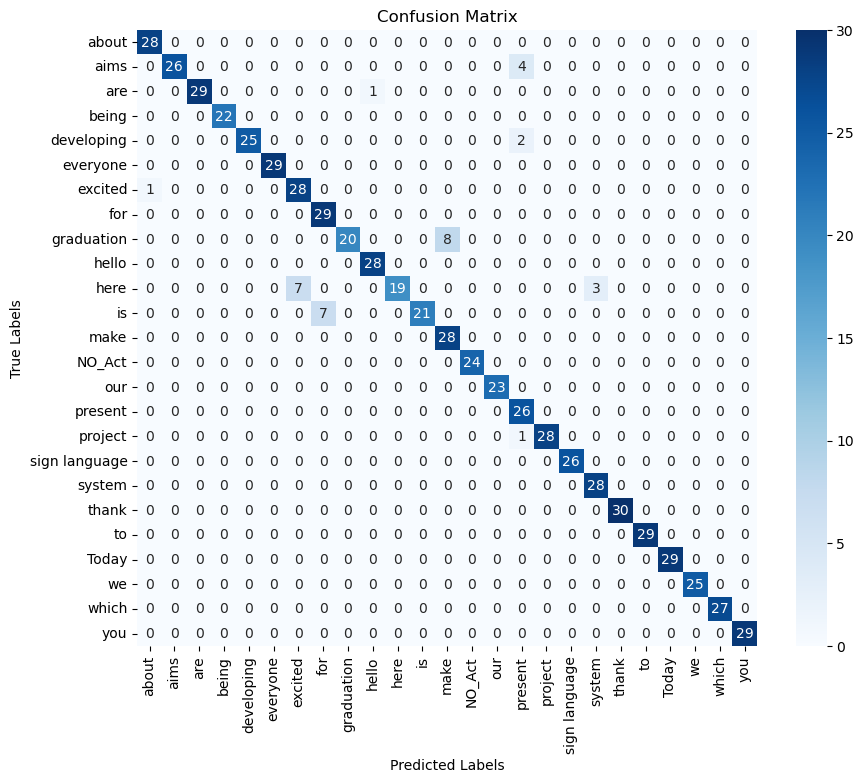

In [116]:
# Define the labels for the categories
labels = actions

#prediction
res = model.predict(X_test)
yhat = model.predict(X_train)

# Get the ytrue & yhat
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

# Compute the confusion matrix
cm = confusion_matrix(ytrue, yhat)

#print predictions & accuracy & classification report
print(actions[np.argmax(res[0])])
print(actions[np.argmax(y_test[0])])
print(accuracy_score(ytrue, yhat))
print(classification_report(y_train.argmax(axis=1), yhat))


# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def plot_acc(model):
# Plot accuracy 
    history = model.history
    epochs = range(len(history['accuracy']))
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, history['accuracy'], 'b-', label="Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()

def plot_loss(model):
    # Plot loss
    history = model.history
    epochs = range(len(history['loss']))
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, history['loss'], 'r-', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.show()

plot_acc(his)
plot_loss(his)

# 10. Save Models & Weights

In [51]:
# save SVM model
joblib.dump(SVM_classifier, 'svm_model.pkl')

['svm.pkl']

In [ ]:
# save Lstm model
model.save('lstm_model.h5')

In [89]:
# delete the model
del model

In [64]:
# load weights for Lstm model
model.load_weights('lstm_model.h5')

# 11. Test in Real Time

In [12]:
# Important variables
sequence = []
sentence = []
predictions = []
threshold = 0.9

# Text-to-speech initialization
engine = pyttsx3.init()

# Load the trained models
lstm_model = tf.keras.models.load_model('lstm_model.h5')
svm_model = joblib.load('svm_model.pkl')

# Open the camera
cap = cv2.VideoCapture(0)

# Set Mediapipe model
mp_holistic = mp.solutions.holistic
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            # Prediction using LSTM and SVM models
            res_lstm = lstm_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Flatten sequence for SVM
            sequence_flat = np.array(sequence).reshape(1, -1)
            
            # Get SVM probabilities
            res_svm_prob = svm_model.predict_proba(sequence_flat)[0]
            
            # Combine predictions using weighted averaging
            lstm_weight = 0.4
            svm_weight = 0.6
            combined_probabilities = lstm_weight * res_lstm + svm_weight * res_svm_prob
            
            # Get final prediction
            combined_prediction = np.argmax(combined_probabilities)
            predictions.append(combined_prediction)
            
            # Visualization and logic
            if np.unique(predictions[-5:])[0] == combined_prediction:
            
                if res_lstm[combined_prediction] > threshold:
                
                    if actions[combined_prediction] != "NO_Act":
                    
                        if len(sentence) > 0:
                            
                            if actions[combined_prediction] != sentence[-1]:
                                sentence.append(actions[combined_prediction])
                                engine.say(actions[combined_prediction])  # Text-to-speech
                                engine.runAndWait()
                        else:
                            sentence.append(actions[combined_prediction])
                            engine.say(actions[combined_prediction])  # Text-to-speech
                            engine.runAndWait()
            if len(sentence) > 5:
                sentence = sentence[-5:]
        
        # Display results on the screen
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Prediction', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━